# Waifu face generation

## Dataset

First download the data from a GoogleDrive folder. (Only Need to do it once)

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
#cd /content/drive/MyDrive/anime_faces

In [9]:
#!ls

Only need to download the data once

In [10]:
# %run download_data.py

In [11]:
#@title Imports
from __future__ import print_function
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as transforms
import numpy as np
import os

seed = 0
torch.manual_seed(seed)
print(f'Torch random seed: {seed}.')

Torch random seed: 0.


In [12]:
#@title Model and training parameters

training_path = "./data/train_1/"

batch_size = 128
image_size = 64
nb_channels = 3

latent_dim = 256

epochs = 20
learning_rate = 1e-4
KL_weight = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# TODO : add training parameters (like latent space dim)

cuda


In [13]:
#@title Dataset class and transforms
training_transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


class ImageSet(Dataset):
    def __init__(self, path, transform, preload=False):
        self.path = path
        self.files = os.listdir(self.path)
        self.transform = transform
        self.preload = preload
        if self.preload:
          self.files = [
              self.transform(
                  Image.open(os.path.join(self.path, file))
              ) for file in self.files]

    def __getitem__(self, index):
        if self.preload:
          return self.files[index]
        else:
          return self.transform(
              Image.open(os.path.join(self.path, self.files[index]))
          )
    
    def __len__(self):
        return len(self.files)

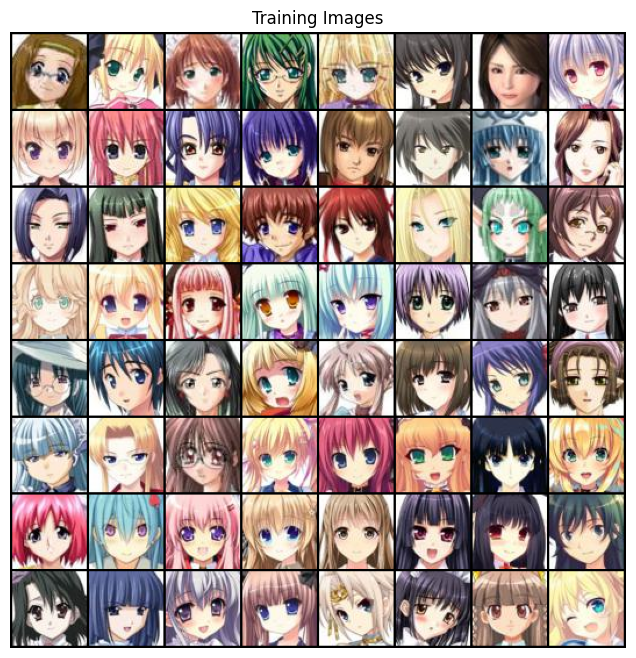

In [14]:
#@title Datasets making
training_set = ImageSet(
    path=training_path,
    transform=training_transform,
    preload=True,
)


training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True
)

# Plot some training images
batch = next(iter(training_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# VAE

In [15]:
class VAE(nn.Module):


    def __init__(self, nb_channels, n_features, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = nb_channels
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= nb_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return  x_hat, mu, log_var

In [16]:
# Create an instance of the VAE model
model = VAE(nb_channels, image_size, latent_dim).to(device)



In [17]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

In [18]:
def vae_loss(x, x_hat, mu, log_var, beta):
    # Reconstruction loss
    #pdb.set_trace()
    #recon_loss = nn.BCELoss(reduction='mean')(x_hat, x)
    recon_loss = F.mse_loss(x, x_hat)

    #recon_loss = (x * torch.log(x_hat) + (1 - x)* torch.log(1 - x_hat)).sum((1, 2, 3)).mean()
    #pdb.set_trace()
    # KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    #pdb.set_trace()
    # Total loss
    loss = recon_loss + beta * kld_loss
    
    return loss


In [19]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [21]:
# Train the model on your dataset
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, x in enumerate(training_loader):
        # Move the input data to the same device as the model
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = vae_loss(x, x_hat, mu, log_var, KL_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, loss={total_loss / len(training_loader.dataset):.4f}")


Epoch 1, loss=0.0031
Epoch 2, loss=0.0021
Epoch 3, loss=0.0018
Epoch 4, loss=0.0017
Epoch 5, loss=0.0017
Epoch 6, loss=0.0017
Epoch 7, loss=0.0017
Epoch 8, loss=0.0017
Epoch 9, loss=0.0017
Epoch 10, loss=0.0017
Epoch 11, loss=0.0016
Epoch 12, loss=0.0016
Epoch 13, loss=0.0016
Epoch 14, loss=0.0016
Epoch 15, loss=0.0016
Epoch 16, loss=0.0016
Epoch 17, loss=0.0016
Epoch 18, loss=0.0015
Epoch 19, loss=0.0015
Epoch 20, loss=0.0015


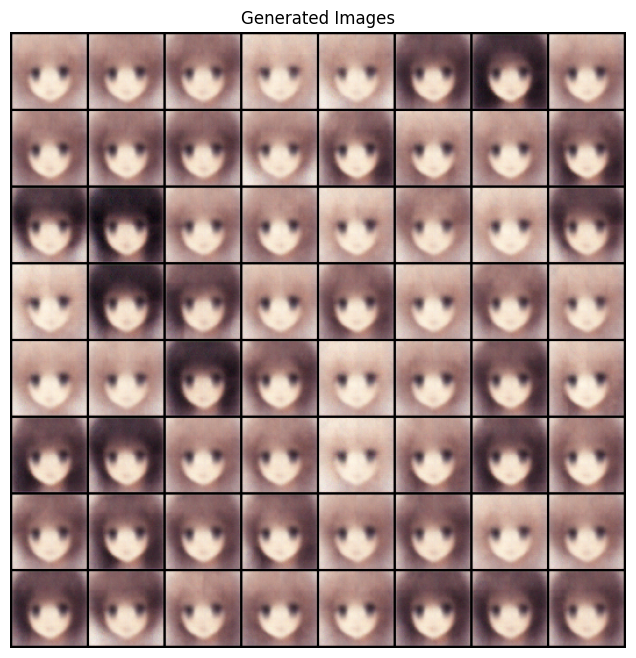

In [25]:
# generate new images
with torch.no_grad():
  random_noise = torch.randn(64, latent_dim, device=device)
  batch = model.decode(random_noise)


plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1,2,0)));